<a href="https://colab.research.google.com/github/shadowluigi27/Projects-in-ML-F22/blob/main/Projects_in_ML_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

I Will be using the tensorflow framework for the RNNs for this assignment

https://www.tensorflow.org/guide/keras/rnn

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential 

This is the source of the Data
https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis 

The reason why we need to use sequence models is because the trend of past stock prices in this case can influence how the stock might behave in the future 

In [320]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,SimpleRNN,GRU, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



# EDA

In [321]:
df = pd.read_csv('Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [322]:
df.shape

(1511, 6)

In [323]:
df.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [324]:
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

no null values, we don't need to remove any rows data

In [325]:
#convert date into timestep data
df.Date = pd.to_datetime(df.Date, yearfirst = True)
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

Text(0, 0.5, 'Stock Price')

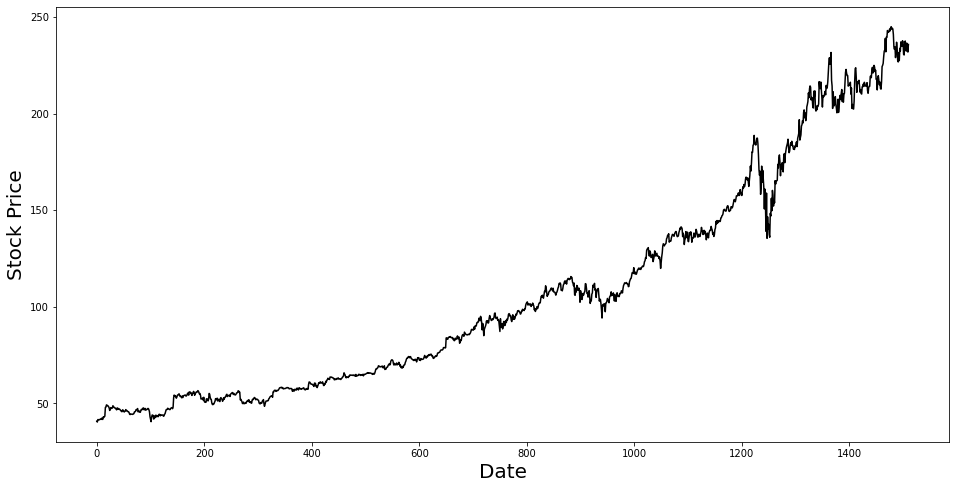

In [326]:
#Show general trend of Microsoft

plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history',color='black')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)

In [327]:
#sns.pairplot(df)

We can see that the most of the data points here are strongly correleated with each other, the only outlier being the Volume Variable

In [328]:
#date is only a marker, there is no real information to be gained from date, so we can drop it

df = df.drop(['Date'],axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,40.60,40.76,40.31,40.72,36865322
1,40.66,40.74,40.12,40.29,37487476
2,40.34,41.78,40.18,41.55,39223692
3,41.61,41.91,41.31,41.53,28809375
4,41.48,41.69,41.04,41.42,24753438


## Part 1

We want to use some window of time in our data to predict the next window of time, since there is about 1511 dates, let us use a window size of 20

Here is the set of functions I will create since we will create 3 models(RNN, LSTM,GRU) we can reuse the functions later on

In [329]:
#Function to normalize data
def normalize_data(data):
    data = data.astype('float32')
    scaler = MinMaxScaler()
    scaler.fit_transform(data)
    return data

In [330]:
#Function to set up consistent data points
def train_validate_test_split(data):
    train_size = int(len(data) * 0.75)
    validate_size = int(len(data) * 0.9)
    train,validate, test = data[0:train_size, :], data[train_size:validate_size, :], data[validate_size:len(data), :]
    return train,validate, test

In [331]:
#Function to create  data  windows 
def window_creation(data):
    x, y = [], []
    for i in range(len(data)):
        end_i = i + 20
        out_i = end_i + 20
        if out_i > len(data):
            break
        seq_x, seq_y = data[i:end_i, :], data[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [332]:
#Our RNN Model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(20, 1)))
model.add(RepeatVector(20))
model.add(SimpleRNN(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

For my purpose, I just want to see how the price in a certain time period affects the price in the future. Since start/Max/end prices are so similar, we can just use one of them for our purposes

In [333]:
data = df['Close'].values
data = data.reshape(-1, 1)

data = normalize_data(data)
train,validate, test = train_validate_test_split(data)
x_train, y_train = window_creation(train)
x_validate, y_validate = window_creation(validate)
x_test, y_test = window_creation(test)

In [334]:
history = model.fit(x_train, y_train, epochs=50, batch_size=144, verbose=1,
         validation_data=(x_validate, y_validate))

Epoch 1/50
8/8 [==============================] - 3s 117ms/step - loss: 2385.7141 - mean_squared_error: 2385.7144 - val_loss: 2076.2043 - val_mean_squared_error: 2076.2043
Epoch 2/50
8/8 [==============================] - 0s 25ms/step - loss: 444.3824 - mean_squared_error: 444.3824 - val_loss: 1585.9032 - val_mean_squared_error: 1585.9032
Epoch 3/50
8/8 [==============================] - 0s 36ms/step - loss: 228.4984 - mean_squared_error: 228.4984 - val_loss: 957.6462 - val_mean_squared_error: 957.6462
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 166.1734 - mean_squared_error: 166.1734 - val_loss: 666.8765 - val_mean_squared_error: 666.8766
Epoch 5/50
8/8 [==============================] - 0s 23ms/step - loss: 134.7773 - mean_squared_error: 134.7773 - val_loss: 567.3392 - val_mean_squared_error: 567.3392
Epoch 6/50
8/8 [==============================] - 0s 33ms/step - loss: 105.9157 - mean_squared_error: 105.9157 - val_loss: 494.3336 - val_mean_squared_error: 

In [335]:
results = model.evaluate(x_test, y_test, batch_size=144)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 24ms/step - loss: 79.0040 - mean_squared_error: 79.0040
test loss, test acc: [79.00399780273438, 79.00399780273438]


## Part 2
Replace Simple RNN with LSTM and GRU

In [336]:
#Our LSTM Model
model2 = Sequential()
model2.add(LSTM(50, activation='relu', input_shape=(20, 1)))
model2.add(RepeatVector(20))
model2.add(LSTM(50, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(1)))
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [337]:
data = df['Close'].values
data = data.reshape(-1, 1)

data = normalize_data(data)
train,validate, test = train_validate_test_split(data)
x_train, y_train = window_creation(train)
x_validate, y_validate = window_creation(validate)
x_test, y_test = window_creation(test)

In [338]:
history = model2.fit(x_train, y_train, epochs=50, batch_size=144, verbose=1,
         validation_data=(x_validate, y_validate))

Epoch 1/50
8/8 [==============================] - 5s 207ms/step - loss: 10203.8174 - mean_squared_error: 10203.8174 - val_loss: 34654.5039 - val_mean_squared_error: 34654.5078
Epoch 2/50
8/8 [==============================] - 0s 50ms/step - loss: 2672.5525 - mean_squared_error: 2672.5522 - val_loss: 17297.3535 - val_mean_squared_error: 17297.3535
Epoch 3/50
8/8 [==============================] - 0s 49ms/step - loss: 2168.1694 - mean_squared_error: 2168.1694 - val_loss: 16207.7676 - val_mean_squared_error: 16207.7666
Epoch 4/50
8/8 [==============================] - 0s 53ms/step - loss: 1938.0170 - mean_squared_error: 1938.0170 - val_loss: 9927.6963 - val_mean_squared_error: 9927.6963
Epoch 5/50
8/8 [==============================] - 0s 50ms/step - loss: 1808.5262 - mean_squared_error: 1808.5261 - val_loss: 7876.0093 - val_mean_squared_error: 7876.0098
Epoch 6/50
8/8 [==============================] - 0s 50ms/step - loss: 1802.4491 - mean_squared_error: 1802.4489 - val_loss: 7516.4653 -

In [339]:
results = model2.evaluate(x_test, y_test, batch_size=144)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 38ms/step - loss: 264.0083 - mean_squared_error: 264.0083
test loss, test acc: [264.0083312988281, 264.0083312988281]


GRU model


In [340]:
#Our LSTM Model
model3 = Sequential()
model3.add(GRU(50, activation='relu', input_shape=(20, 1)))
model3.add(RepeatVector(20))
model3.add(GRU(50, activation='relu', return_sequences=True))
model3.add(TimeDistributed(Dense(1)))
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [341]:
data = df['Close'].values
data = data.reshape(-1, 1)

data = normalize_data(data)
train,validate, test = train_validate_test_split(data)
x_train, y_train = window_creation(train)
x_validate, y_validate = window_creation(validate)
x_test, y_test = window_creation(test)

In [342]:
history = model3.fit(x_train, y_train, epochs=50, batch_size=144, verbose=1,
         validation_data=(x_validate, y_validate))

Epoch 1/50
8/8 [==============================] - 4s 113ms/step - loss: 6257.3853 - mean_squared_error: 6257.3857 - val_loss: 22579.9336 - val_mean_squared_error: 22579.9336
Epoch 2/50
8/8 [==============================] - 0s 47ms/step - loss: 3842.1138 - mean_squared_error: 3842.1133 - val_loss: 11228.5479 - val_mean_squared_error: 11228.5469
Epoch 3/50
8/8 [==============================] - 0s 47ms/step - loss: 1502.3032 - mean_squared_error: 1502.3032 - val_loss: 1599.6088 - val_mean_squared_error: 1599.6088
Epoch 4/50
8/8 [==============================] - 0s 52ms/step - loss: 352.6115 - mean_squared_error: 352.6115 - val_loss: 693.5213 - val_mean_squared_error: 693.5213
Epoch 5/50
8/8 [==============================] - 0s 55ms/step - loss: 120.4070 - mean_squared_error: 120.4071 - val_loss: 744.5900 - val_mean_squared_error: 744.5900
Epoch 6/50
8/8 [==============================] - 0s 54ms/step - loss: 126.6110 - mean_squared_error: 126.6110 - val_loss: 399.4129 - val_mean_squar

In [343]:
results = model3.evaluate(x_test, y_test, batch_size=144)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 31ms/step - loss: 105.3524 - mean_squared_error: 105.3524
test loss, test acc: [105.35235595703125, 105.35235595703125]


## Part 2 analysis

It seems like the regualr RNN model and the GRU Model seems to have the best accuracy and least mean squared error. In the way I did the modeling, which was to window the time period of where I am looking, it negated most of the advantages that LSTM has over GRU and RNN modeling.

## Part 3

You could use a traditional Feed-forward network to solve the same problem by transforming the time-series data to a one-hot-encoding. Which although would give way too many features, is still possible